[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciri/iese-dsfb/blob/main/notebooks/410-Airline-Text-Analytics-Part-II.ipynb)

# Airline Text Analytics Part II

As part of an effort to better understand passenger satisfaction within the Star Alliance network, we analyze customer reviews from thousands of airline passengers both in and outside of network. The goal is to identify how factors like sentiment, seat type, travel purpose, and specific routes relate to overall recommendation rates.

The dataset includes 23,000+ reviews, with key variables such as:

- `Airline Name`: the name of the airline.
- `Route`: the flight route taken by the passenger.
- `Review`: free-text review written by the traveler.
- `Type Of Traveller`: e.g., Solo Leisure, Business, Couple.
- `Recommended`: whether the traveler recommends the airline (yes/no).
- `Seat Type`: seat class (e.g., Economy, Business).

Data Source: [Airlinequality.com](https://www.airlinequality.com/) via [Kaggle](https://www.kaggle.com/datasets/khushipitroda/airline-reviews/data)

### Importing the data

We've already partially cleaned the data and explored it. Let's now look into a couple more advanced text-analytics.

In [2]:
import pandas as pd

pd.set_option('display.max_colwidth', None) # This allow me to see the whole passage of a text review.

## Better: store it locally first, then open it
df = pd.read_csv('../resources/text/Airline_Reviews.csv')[['Airline Name','Route','Review','Type Of Traveller','Recommended','Seat Type']]
## Download every time, works but is slower:
# df = pd.read_csv('https://raw.githubusercontent.com/ciri/iese-dsfb/refs/heads/main/resources/text/Airline_Reviews.csv')[['Airline Name','Route','Review','Type Of Traveller','Recommended','Seat Type']]

df.head()

,Airline Name,Route,Review,Type Of Traveller,Recommended,Seat Type
0,AB Aviation,Moroni to Moheli,"Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.",Solo Leisure,yes,Economy Class
1,AB Aviation,Moroni to Anjouan,"Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the office of AB Aviation which was still closed. It opened at 0900hrs and I was told that the flight had been put back to 1300hrs and that they had tried to contact me. This could not be true as they did not have my phone number. I was with a local guide and he had not been informed either. I presume that I was bumped off. The later flight did operate but as usual, there was confusion at check-in. The flight was only 30mins and there were no further problems. Not a good airline but it is the only one for Comoros.",Solo Leisure,no,Economy Class
2,AB Aviation,Anjouan to Dzaoudzi,"Anjouan to Dzaoudzi. A very small airline and the only airline based in Comoros. Check-in was disorganised because of locals with big packages and disinterested staff. The flight was fortunately short (30 mins). Took off on time and landed on time. With a short flight like there was of course no in-flight entertainment nor cabin service except for biscuits and a bottle of water, which was quite nice!",Solo Leisure,no,Economy Class
3,Adria Airways,Frankfurt to Pristina,"Please do a favor yourself and do not fly with Adria. On the route from Munich to Pristina in July 2019 they lost my luggage and for 10 days in a row, despite numerous phone calls they were not able to locate it. 11 days later the luggage arrived at the destination completely ruined. Applying for compensation, they ignored my request. Foolishly again, I booked another flight with them (345 euros) Frankfurt - Pristina in September 2019. They cancelled the flight with no reason 24 hours before the departure. Desperate phone calls to customer service to get anything (rerouting, compensation, etc) were not responded. I will never fly again with Adria. What a disgrace! Shame on you Adria for constantly deceiving your customers.",Solo Leisure,no,Economy Class
4,Adria Airways,Sofia to Amsterdam via Ljubljana,"Do not book a flight with this airline! My friend and I should have returned from Sofia to Amsterdam on September 22 and 3 days before, they sent us an SMS informing the flight was cancelled. For 3 straight days we tried to reach the airline and the web agent (e-dreams) and we did not get a solution. Finally, 18 hours before our cancelled flight time, and after 35 minutes on a call (waiting), the airline was able to get us on a flight with Lufthansa. Do not book Adria Airways, it is unreliable and in our case, it ruined our last days of holidays since we needed to be on the phones all day.",Couple Leisure,no,Economy Class


## Sentiment analysis

Sentiment analysis is a natural language processing (NLP) technique used to identify and quantify emotions in text. It is a staple of marketing analytics, as it helps companies understand how customers feel about their brand, products, or services by analyzing reviews, social media, and survey responses. 

Let us try to see if we can discover any postive or negative trends in the flight experience.

### Approach 1: ad-hoc

In [3]:
good = df.Review.str.lower().str.contains('good')
bad  = df.Review.str.lower().str.contains('bad')

print(good.mean(), bad.mean())

0.21608956001041396 0.09767421678382365


**You try it**

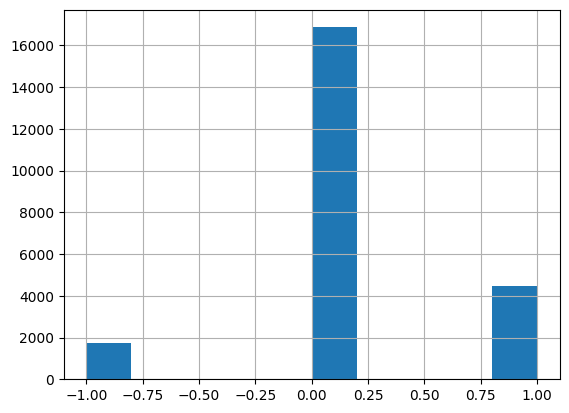

In [4]:
df['simple_sentiment'] = good.astype(int) - bad.astype(int)
df.simple_sentiment.hist();

**Litmus test**

This all feels a bit ad-hoc and we should probably validate this with the recommendations to make sure the sentiment makes sense ...

In [5]:
df["Recommended01"] = (df.Recommended == 'yes').astype(int)
df[['simple_sentiment','Recommended01']].corr()

,simple_sentiment,Recommended01
simple_sentiment,1.000000,0.319901
Recommended01,0.319901,1.000000


### Approach 2: lexicon-based

The VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon was developed by C.J. Hutto and Eric Gilbert in 2014 at Georgia Tech. They first collected sentiment ratings from human annotators for thousands of words and phrases, then used statistical methods to fine-tune these scores. The final dictionary captures not only the polarity (positive/negative) of words but also their intensity, making it especially effective for short, informal text like tweets or product reviews.

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon');
sia = SentimentIntensityAnalyzer();

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/enric/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Let us start by inspecting the lexicon.

In [7]:
sia.lexicon

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

You can look up the individual valences of a word using the set get method:

In [8]:
sia.lexicon.get("amazing")

2.8

To apply it to paragraph of text, use the `polarity_scores` method. It returns a set of scores where neg is the negative valence, pos the positive valence and neu the neutral valence. Compound is a smart combination of valences of all the words in the sentence:
$$
\text{compound} = \frac{\sum_{i=1}^{n} s_i}{\sqrt{\left(\sum_{i=1}^{n} s_i\right)^2 + 15}}
$$
Which yields a value between -1 (negative) and +1 (positive).

In [9]:
sia.polarity_scores('I really loved the snacks on the flight!')

{'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'compound': 0.6689}

This is not a pandas function, so to apply it to all elements of a column we must (a) define a function, (b) use the `apply` method to apply it to all elements of the column.

In [ ]:
# If you are on an old computer, you may need to use the sample instead as this could take a minute or two.
def get_sentiment(review):
    return sia.polarity_scores(review)['compound']

df['sentiment'] = df['Review'].apply(get_sentiment)

To get a progress bar while you do this, import the `tqdm` package and use `.progress_apply` instead.

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['sentiment'] = df['Review'].progress_apply(get_sentiment)

100%|██████████| 23046/23046 [00:12<00:00, 1832.54it/s]


**You try it**

Show the top 2 most positive and negative reviews.

**Litmus test**

Apply the correlation test, what do you find?

Not too bad, still, the above method is very crude and can't handle things like negation. We can go beyond that by using machine learning, especially models trained on large datasets of human-labeled text.

### Approach 3: Machine Learning

A popular family of machine learning approaches to sentiment analysis is BERT (Bidirectional Encoder Representations from Transformers). Once you know how to use them, they become the swiss army knife of text analytics. BERT models have been fine-tuned for tasks like:
* Sentiment analysis
* Text classification
* Topic detection
* ...

If you have a powerful machine, you could try [this one](https://huggigface.co/cirimus/modernbert-base-go-emotions), created by your professor. It's trained to recognize a wide range of emotions in modern language.

But for now, let's keep it simple with a lightweight version of BERT, already fine-tuned for sentiment:
`distilbert-base-uncased-finetuned-sst-2-english`. It's fast, free to use, and good enough to show the power of transformer models over rule-based methods.

Note: this may not run on all computers, if it doesn't on yours, switch to google collab.

In [ ]:
#! pip install transformers torch
from transformers import pipeline

# Lightweight BERT-based sentiment analyzer
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english",truncation  = True,  max_length  = 512)

def scored_sentiment(text):
    result = sentiment_model(text)[0]
    return result['score'] if result['label'] == 'POSITIVE' else -result['score']

scored_sentiment('Best. Flight. Ever.')

**You try it**

Use the `.progress_apply` function to apply sentiment scoring to all BERT sentiments.

In [22]:
sample = df.sample(1000, random_state=42)

### Who are the Stars in Star Alliance?

Now that we have the sentiment, let us try to rank airlines by sentiment. Use either the lexicon based sentiment or BERT depending on what worked for you.

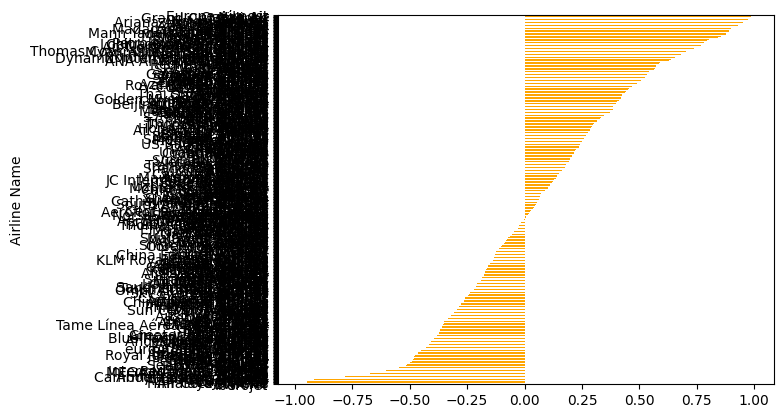

In [11]:
df.groupby('Airline Name')['sentiment'].mean().sort_values(ascending=True).plot.barh(color='orange');

For the sake of our analysis, let us drop any airline company with less than 10 reviews. Instead, we may just analyze star alliance airline companies:

In [16]:
# I asked ChatGPT to write this code for me
star_alliance_members = [
    'Aegean Airlines',
    'Air Canada',
    'Air China',
    'Air India',
    'ANA All Nippon Airways',
    'Asiana Airlines',
    'Austrian Airlines',
    'Avianca',
    'Brussels Airlines',
    'Copa Airlines',
    'Croatia Airlines',
    'Egyptair',
    'Ethiopian Airlines',
    'Eva Air',
    'LOT Polish Airlines',
    'Lufthansa',
    'Scandinavian Airlines',
    'Shenzhen Airlines',
    'Singapore Airlines',
    'South African Airways',
    'Swiss International Air Lines',
    'TAP Portugal',
    'Thai Airways',
    'Turkish Airlines',
    'United Airlines'
]

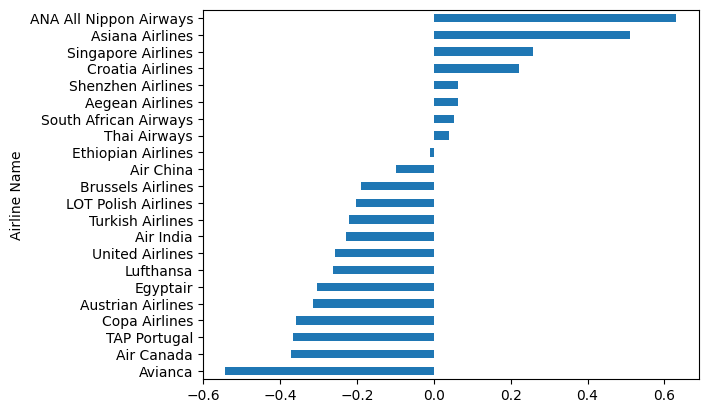

In [23]:
f_star_alliance = df['Airline Name'].isin(star_alliance_members)
df_star = df[f_star_alliance].copy()

star_sentiments = df_star.groupby('Airline Name')[['sentiment']].mean()
star_sentiments['sentiment'].sort_values().plot.barh();

What follow-up analysis would you do if you were working at star alliance?

## Beyond Sentiment

There are vast repositories of different machine learning models that can handle NLP tasks. For a quick look, check out the [HuggingFace NLP repository](https://huggingface.co/models). Still, sometimes you may want to do something "custom" to your situation. In this case, you have two choices:

1. Fine-tune your own BERT model (take the ML class)
2. Use LLM data annotation

Let's try to do the latter. For this you will first need to follow the following steps:

1. Create a [Google account](https://accounts.google.com/), or login to your existing one.
2. Create a [Gemini API key](https://aistudio.google.com/app/apikey) (this is free, but [usage limitations](https://cloud.google.com/gemini/docs/quotas#daily) apply).
3. Open a python environment to follow along.

In [ ]:
API_KEY = '...'

This allows you to talk to google's models directly from python:

In [35]:
# ! pip install -q -U google-genai
from google import genai

client = genai.Client(api_key=API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash", contents="Explain in one number what the meaning of life is."
)
print(response.text)

42



LLM data annotation

In [ ]:
df_ana = df[df['Airline Name'] == 'ANA All Nippon Airways']
df_ana[['Airline Name','Review']].head()

,Airline Name,Route,Review,Type Of Traveller,Recommended,Seat Type,sentiment,Recommended01
4350,ANA All Nippon Airways,Vancouver to Sydney via Tokyo,"Pretty disappointed with ANA, especially whe...",Business,no,Business Class,0.8405,0
4351,ANA All Nippon Airways,Tokyo Haneda to London Heathrow,"Great service, lovely crew, comfortable seat...",Business,yes,Economy Class,0.9852,1
4352,ANA All Nippon Airways,Seattle to Tokyo,"Overall was a good experience, check in went ...",Couple Leisure,yes,Business Class,0.6249,1
4353,ANA All Nippon Airways,Tokyo to Los Angeles,Paid for seats so entire family is together. ...,Family Leisure,no,Economy Class,-0.7841,0
4354,ANA All Nippon Airways,San Francisco to Beijing via Tokyo,I’m super unhappy about ANA service. They ask...,Family Leisure,no,Premium Economy,-0.2732,0


Start by going to your favorite LLM, and trying to annotate your data.

In [ ]:
PROMPT = """
You're a world-class customer service analyst who is analyzing airline reviews.
Score the crew on the flight (friendliness, professionalism, helpfulness) from 0 to 10.
If crew is not mentioned, return 'N/A'.

Also extract the most relevant passage that supports your score.

Format your response as:

<score>YOUR_SCORE_HERE</score><passage>YOUR_PASSAGE_HERE</passage>

Important: only reply with the required tags and scores. Don't add anything else, you MUST use both tags.
"""
def score_crew(review_text):
    prompt = PROMPT + "\nReview:" + review_text
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )
    return response.text.strip()

score_crew('the crew was amazing. the food was good too.')

'<score>10</score><passage>the crew was amazing.</passage>'

**You try it**

1. Apply the scoring on a df_sample below.
2. Create a CrewScore column and Rationale column.

Hint: look at the llm_scores and find out what the best string splits are.
Hint2: this sometimes doesn't work as LLMs can make mistakes/hallucinate, so make sure to filter out any rows that do not contain the required tags (e.g. `<score>`)

In [112]:
df_sample = df.sample(50, random_state=42)